In [15]:

from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import pprint
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)

def explode_measures(df, new_columns, columns):
    for column in columns:
        df[column] = df[column].apply(eval)

    exploded = df.explode(columns).reset_index(drop=True)

    for new_column, column in zip(new_columns, columns):
        exploded[["attack_epsilon",new_column]] = pd.DataFrame(exploded[column].tolist(), index=exploded.index)

    exploded = exploded.drop(columns=columns)
    return exploded

def explode_erm_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","adversarial_generalization_errors_overlap","fair_adversarial_errors","test_losses"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","adversarial_generalization_error_overlap","fair_adversarial_error","test_loss"]
    return explode_measures(df, new_columns, columns)

def explode_state_evolution_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","test_losses"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","test_loss"]
    return explode_measures(df, new_columns, columns)
    
df_erm = explode_erm_measures(df_erm)
df_state_evolution = explode_state_evolution_measures(df_state_evolution)
    

print("Current code version, ", __version__)

Current code version,  83


In [17]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "68"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(3)

,experiment_id,experiment_name,duration,problem_types,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,...,taus,ps,dp,d,experiment_type,completed,data_model_type,data_model_name,data_model_description,gamma_fair_error
177,e79ae4a4-7e21-4f4b-a25e-b861151ad59a,"Sweep Alpha - KFeaturesModel - - 2 Features, ...",45.940392,"[""Logistic""]",83,2023-11-22 13:08:27,1,2,"[0.5, 2.0]","[0.0, 0.4]",...,[0],null,0.01,1000,SweepAtOptimalLambdaAdversarialTestError,1,KFeaturesModel,,"2 Features, Theta Identity, Sigma_delta Identity",0.01


In [18]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [19]:
experiment_loc = 0

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the data model type and data_model name used
data_model_type = df_experiments.iloc[experiment_loc]["data_model_type"]
# convert it to the enum
data_model_type = DataModelType[data_model_type]
data_model_name = df_experiments.iloc[experiment_loc]["data_model_name"]
data_model_description = df_experiments.iloc[experiment_loc]["data_model_description"]
print(data_model_type.name, data_model_name)
print(data_model_description)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

e79ae4a4-7e21-4f4b-a25e-b861151ad59a
KFeaturesModel 
2 Features, Theta Identity, Sigma_delta Identity
Sweep Alpha - KFeaturesModel -  - 2 Features, Theta Identity, Sigma_delta Identity
['Logistic']


In [20]:
round_to = 1
def my_floor(a, precision=round_to):
    return np.round(a - 0.5 * 10**(-precision), precision)
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
# ceil the alpha values to 1 decimal
state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))
erm = df_erm[df_erm["experiment_id" ] == experiment_id]

gd = erm[erm["chosen_minimizer"] == "sklearn"]
# ceil the alpha values to 1 decimal
gd["alpha"] = gd["alpha"].apply(lambda x: my_floor(x,precision=round_to))


# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon"]) #,"p_calibration"
# from state_evolution keep generalization_error, sigma, q, m, angle
state_evolution = state_evolution[["generalization_error","sigma","q","Q_self","m","angle","training_loss","estimation_error","sigma_hat","q_hat","m_hat","adversarial_generalization_error","training_error","A","N","A_hat","N_hat","test_loss","adversarial_generalization_error_teacher","fair_adversarial_error","F","P"]] #calibration
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	angle
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","angle", "training_error","d", "training_loss","test_loss","adversarial_generalization_error","adversarial_generalization_error_overlap","A","N", "adversarial_generalization_error_teacher","fair_adversarial_error","P","F"]] #,"erm_calibration","analytical_calibration"
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes (if a value is missing in one of the two dataframes, it is filled with NaN)
df = state_evolution.join(gd, how="outer")
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm',"Q_self_state_evolution",'m_state_evolution','m_erm','angle_state_evolution','angle_erm', 'rho_erm',"training_loss_state_evolution","training_loss_erm","training_error_erm","d_erm","test_loss_erm","estimation_error_state_evolution","sigma_hat_state_evolution","q_hat_state_evolution","m_hat_state_evolution","adversarial_generalization_error_state_evolution","adversarial_generalization_error_overlap_erm","adversarial_generalization_error_erm","training_error_state_evolution","A_erm","N_erm","A_state_evolution","N_state_evolution","A_hat_state_evolution","N_hat_state_evolution","test_loss_state_evolution", "adversarial_generalization_error_teacher_erm","adversarial_generalization_error_teacher_state_evolution","fair_adversarial_error_state_evolution","fair_adversarial_error_erm","P_state_evolution","P_erm","F_state_evolution","F_erm"]] #,"erm_calibration_erm","analytical_calibration_erm","calibration_state_evolution"
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3,4,5]).agg(["mean","std"]) #,4
# display all columns
pd.set_option('display.max_columns', None)
# # display all rows
# pd.set_option('display.max_rows', None)
df.sort_index()
df

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_77532/2421026200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))


generalization_error_state_evolution  \
                                                                                        mean   
alpha epsilon tau lam       problem_type attack_epsilon                                        
0.4   0.0     0.0 99.999998 Logistic     0.2                                        0.331186   
      0.4     0.0 99.999997 Logistic     0.2                                        0.383064   
2.0   0.0     0.0 99.999998 Logistic     0.2                                        0.230187   
      0.4     0.0 99.999998 Logistic     0.2                                        0.326910   

                                                              \
                                                         std   
alpha epsilon tau lam       problem_type attack_epsilon        
0.4   0.0     0.0 99.999998 Logistic     0.2             0.0   
      0.4     0.0 99.999997 Logistic     0.2             0.0   
2.0   0.0     0.0 99.999998 Logistic     0.2             0.0   
      0.4     0.0 99.999998 Logistic     0.2             0.0   

                                                        generalization_error_erm_erm  \
                                                                                mean   
alpha epsilon tau lam       problem_type attack_epsilon                                
0.4   0.0     0.0 99.999998 Logistic     0.2                                 0.33120   
      0.4     0.0 99.999997 Logistic     0.2                                 0.39270   
2.0   0.0     0.0 99.999998 Logistic     0.2                                 0.22815   
      0.4     0.0 99.999998 Logistic     0.2                                 0.32570   

                                                                   \
                                                              std   
alpha epsilon tau lam       problem_type attack_epsilon             
0.4   0.0     0.0 99.999998 Logistic     0.2             0.008202   
      0.4     0.0 99.999997 Logistic     0.2             0.003960   
2.0   0.0     0.0 99.999998 Logistic     0.2             0.003606   
      0.4     0.0 99.999998 Logistic     0.2             0.010465   

                                                        generalization_error_overlap_erm  \
                                                                                    mean   
alpha epsilon tau lam       problem_type attack_epsilon                                    
0.4   0.0     0.0 99.999998 Logistic     0.2                                    0.329100   
      0.4     0.0 99.999997 Logistic     0.2                                    0.387725   
2.0   0.0     0.0 99.999998 Logistic     0.2                                    0.232057   
      0.4     0.0 99.999998 Logistic     0.2                                    0.325815   

                                                                   \
                                                              std   
alpha epsilon tau lam       problem_type attack_epsilon             
0.4   0.0     0.0 99.999998 Logistic     0.2             0.002368   
      0.4     0.0 99.999997 Logistic     0.2             0.003364   
2.0   0.0     0.0 99.999998 Logistic     0.2             0.005296   
      0.4     0.0 99.999998 Logistic     0.2             0.002997   

                                                        sigma_state_evolution  \
                                                                         mean   
alpha epsilon tau lam       problem_type attack_epsilon                         
0.4   0.0     0.0 99.999998 Logistic     0.2                         0.014969   
      0.4     0.0 99.999997 Logistic     0.2                         0.005048   
2.0   0.0     0.0 99.999998 Logistic     0.2                         0.014877   
      0.4     0.0 99.999998 Logistic     0.2                         0.003152   

                                                              \
                                                         std   
alpha ep

In [21]:
optimal_lambdas = load_csv_to_object_dictionary(OptimalLambdaResult(0,0,0,0,None,None,None),path="experiments/")
def extract_optimal_lambda(alpha, epsilon, tau, data_model_type, data_model_name, problem_type):
    # extract or compute optimal lamba and plot it as a vertical line
    optimal_result = OptimalLambdaResult(alpha,epsilon,tau,1,data_model_type,data_model_name, problem_type)
    if optimal_result.get_key() in optimal_lambdas:
        optimal_lambda = optimal_lambdas[optimal_result.get_key()]
        return optimal_lambda
    else:   
        print("Optimal lambda not found for ", optimal_result.get_key())
        return None
    

In [22]:
first_iteration = "tau"
second_iteration = "lam" # "lam"
target = "alpha"
sweep = "epsilon"
save_plots = False
description = ""

def get_path(problem_type, filename = None):
    # make sure the directory for the data_model_name exists
    directory = f"Assets/{data_model_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the sweep type as a directory
    sweep_name = f"x_{target}_different_{sweep}_many_{second_iteration}"
    directory = f"Assets/{data_model_name}/{sweep_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the problem type as a directory
    directory = f"Assets/{data_model_name}/{sweep_name}/{problem_type}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    if filename is None:
        filename = description
    
    return f"Assets/{data_model_name}/{sweep_name}/{problem_type}/{filename}"

def create_plot(df, error_name, state_evolution_name, gd_name, log_x = True, log_y=True, fix_a_variable = None, variable_value = None, filename=None, plot_attack_epsilon=False):
    df2 = df.reset_index()
    df2.sort_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]

    attack_epsilons = df2["attack_epsilon"].unique()
    if not plot_attack_epsilon:
        # assign just the first attack_epsilon
        attack_epsilons = [attack_epsilons[0]]

    for attack_epsilon in attack_epsilons:

        for problem_type in df2["problem_type"].unique():

            for tau in df2[first_iteration].unique():

                iterate_over = df2[second_iteration].unique() if second_iteration is not None else [None]

                for lam in iterate_over:

                    fig = plt.figure()
                    ax = plt.subplot(111)

                    # Filter the dataframe for the current values of tau and lam
                    if second_iteration is None:
                        data = df2[(df2[first_iteration] == tau) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon)]
                    else:
                        data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon)]

                    if fix_a_variable is not None:
                        data = data[data[fix_a_variable] == variable_value]
                    
                    for i, epsilon in enumerate(data[sweep].unique()):
                        # Filter the dataframe for the current value of epsilon
                        epsilon_subset = data[data[sweep] == epsilon]

                        # Plot the state_evolution results as a line
                        if state_evolution_name is not None:
                            if state_evolution_name in ["alpha","tau","lam","epsilon"]:
                                ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name)], label=f'{sweep}: {epsilon:.4f}', color=palette[i])
                            else:
                                ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep}: {epsilon:.4f}', color=palette[i])
                        
                        # Plot the gradient_descent results as points with error bars
                        if gd_name is not None:
                            try:
                                ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                            except:
                                pass

                        if error_name == "Generalization Error" and target == "lam":
                            optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau, data_model_type=data_model_type, data_model_name=data_model_name, problem_type=ProblemType[problem_type])
                            # plot the optimal lambda as a vertical line
                            if optimal_lambda is not None:
                                ax.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

                    
                    if log_x:
                        plt.xscale('log')
                        # plt.xscale('symlog')
                    if log_y:
                        plt.yscale('log')

                    # Add labels and title
                    plt.xlabel(target)
                    plt.ylabel(error_name)
                    title = f"{error_name} - {problem_type} - {first_iteration}: {tau},"
                    if fix_a_variable is not None:
                        if second_iteration is None:
                            title += f' d: {d} - {fix_a_variable}: {variable_value}'
                        else:
                            title += f' {second_iteration}: {lam}, d: {d} - {fix_a_variable}: {variable_value}'
                    else:
                        if second_iteration is None:
                            title += f' d: {d}'
                        else:
                            title += f' {second_iteration}: {lam}, d: {d}'
                    if plot_attack_epsilon:
                        title += f" - attack_epsilon: {attack_epsilon}"
                    plt.title(title,y=1.1)
                    

                    box = ax.get_position()
                    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

                    # Put a legend to the right of the current axis
                    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

                    # add a grid
                    plt.grid()

                    plt.tight_layout()

                    if fix_a_variable is not None:
                        name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
                    else:
                        name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
                    if plot_attack_epsilon:
                        name += f"_attack_epsilon_{attack_epsilon}"
                    # Save the plot as svg
                    if filename is not None or save_plots:


                        path = get_path(problem_type, filename)

                        plt.savefig(f"{path}_{name}.pdf", bbox_inches='tight')

                    # Show the plot
                    plt.show()


In [23]:
# Write some code to store all information about the data_model in a json file next to all the plots
if save_plots:
    for problem_type in experiment_problem_types:
        path = get_path(problem_type)

        # get an ExperimentInformation object from one entry in df_experiments
        experiment = ExperimentInformation.from_df(df_experiments.iloc[experiment_loc])

        # load the data_model and store it in a dictionary
        data_model = experiment.get_data_model(logger,source_pickle_path="")
        data_model_dict = data_model.__dict__
        # remove the logger from the dictionary
        del data_model_dict["logger"]
        # add the code version to the dictionary
        data_model_dict["code_version"] = __version__
        # add the experiment_id to the dictionary
        data_model_dict["experiment_id"] = experiment_id
        # add the experiment_name to the dictionary
        data_model_dict["experiment_name"] = experiment_name
        # add the experiment_problem_types to the dictionary
        data_model_dict["experiment_problem_types"] = experiment_problem_types

        # remove all _abc_data
        for key in list(data_model_dict.keys()):
            if "_abc" in key:
                del data_model_dict[key]
            
        # remove all methods
        for key in list(data_model_dict.keys()):
            if callable(data_model_dict[key]):
                del data_model_dict[key]

        

        # store the dictionary as a json file
        with open(f"{path}_data_model.json", 'w') as fp:
            pp = pprint.PrettyPrinter(indent=4)
            text = pp.pformat(data_model_dict)
            fp.write(text)
            

In [24]:
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=1.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=2.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=5.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=15.0)

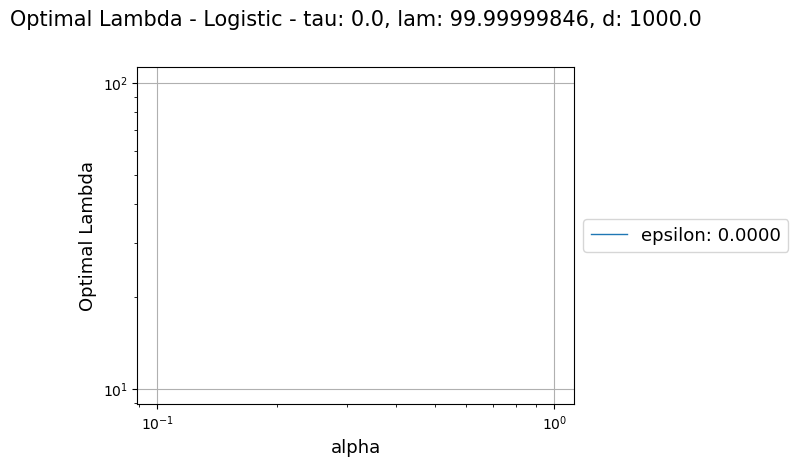

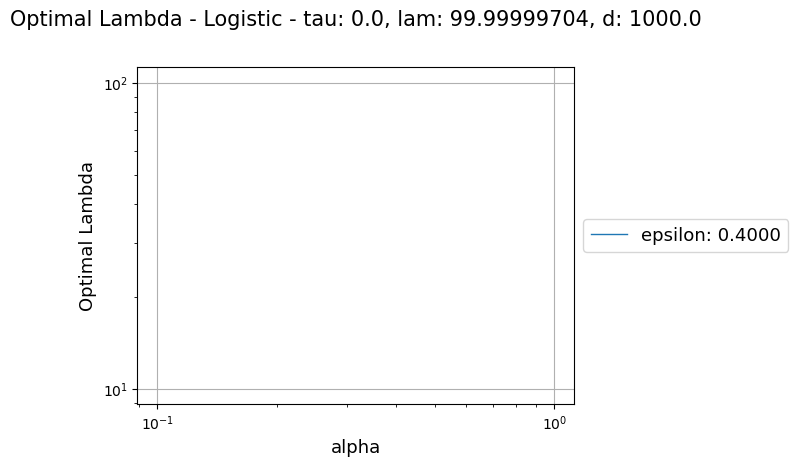

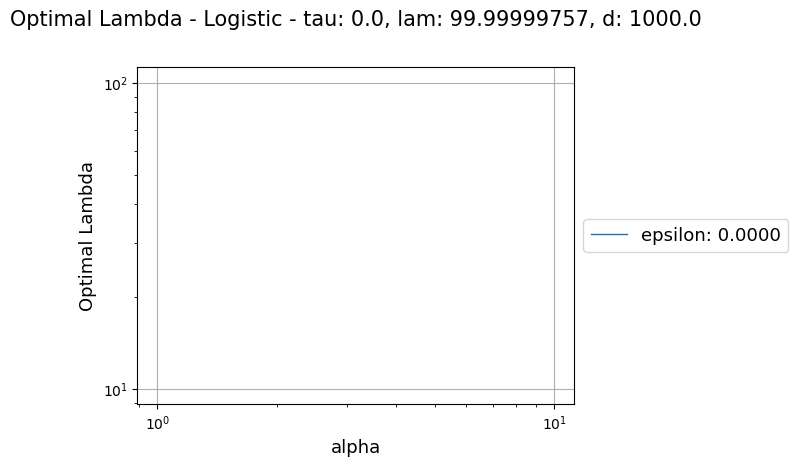

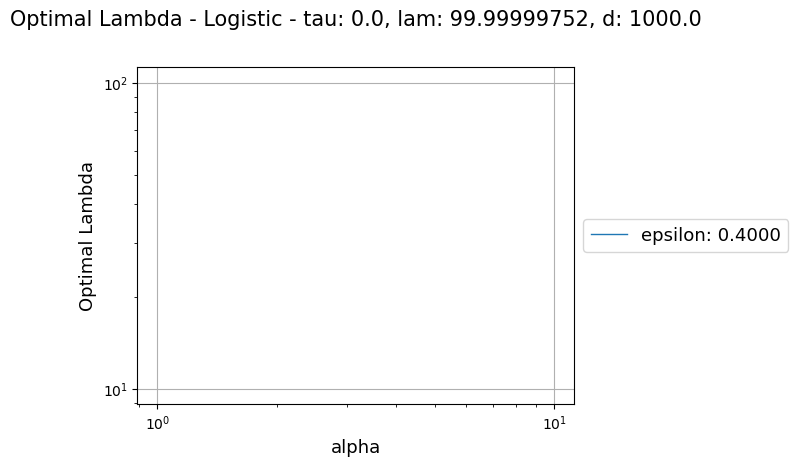

In [25]:
create_plot(df,"Optimal Lambda", "lam", None,filename="Optimal_lambda")

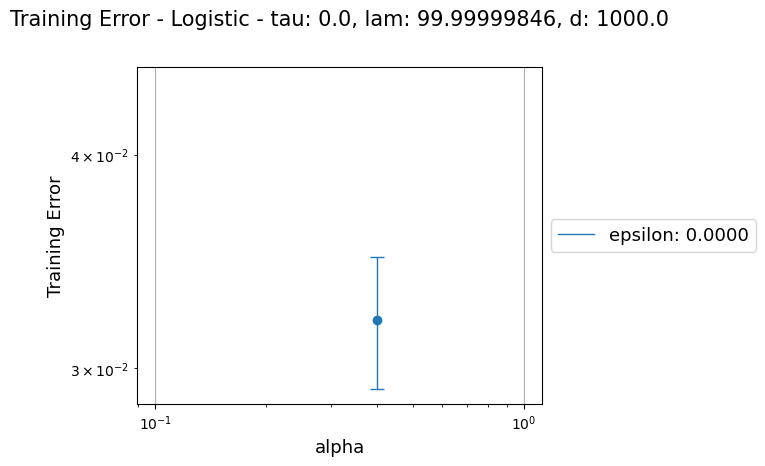

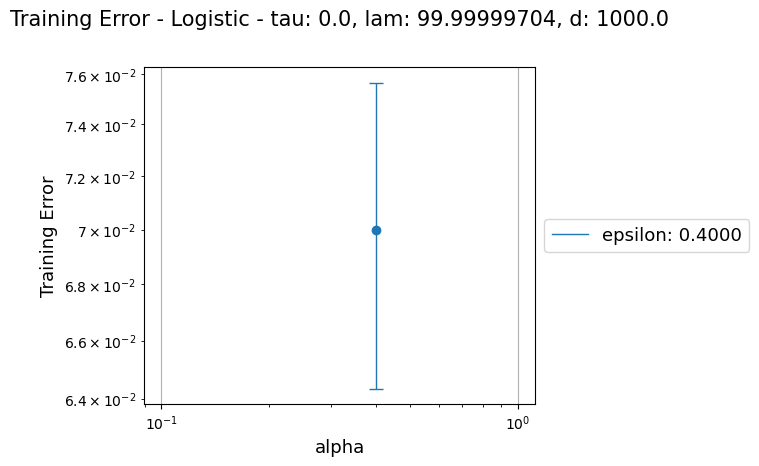

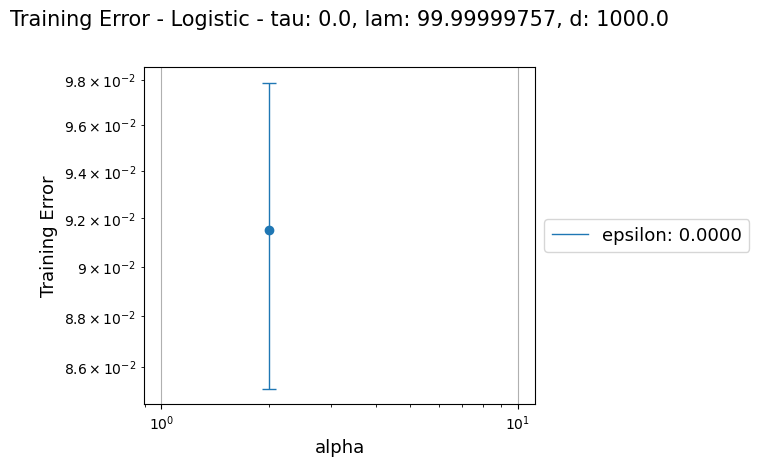

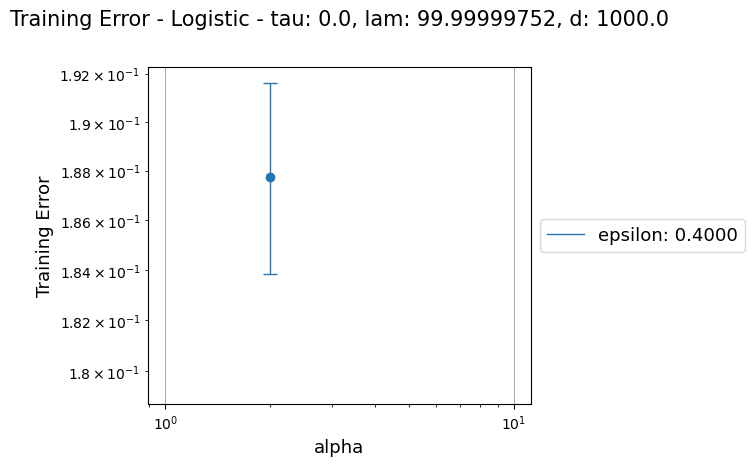

In [26]:
# plot the erm training error
create_plot(df, "Training Error", "training_error_state_evolution","training_error_erm")

In [27]:
# # Let's add a new column to the dataframe for the training error in terms of erm overlaps, except for sigma

# df.apply()

# training_error_overlaps: float = training_error_logistic(m,Q,sigma,A,N,rho,n/d,tau,epsilon, lam)

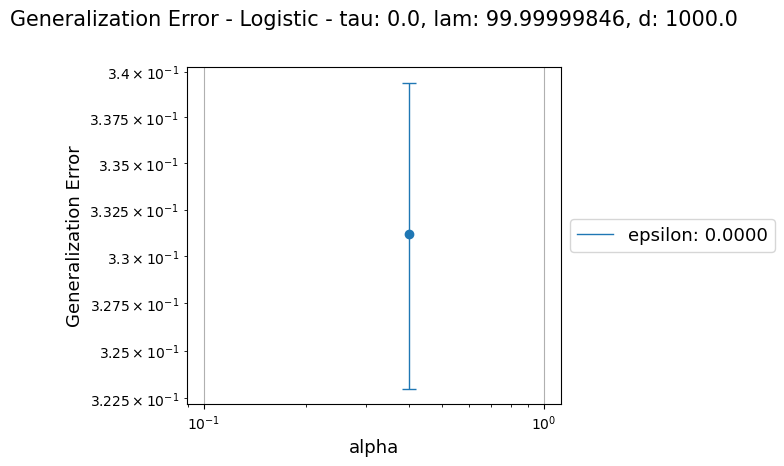

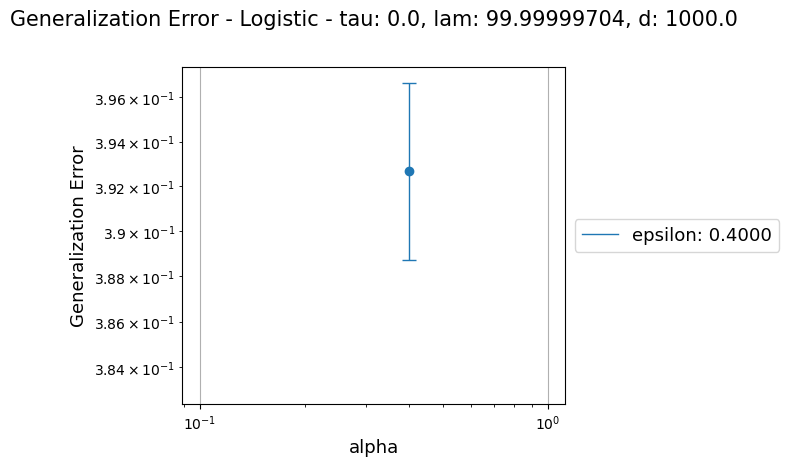

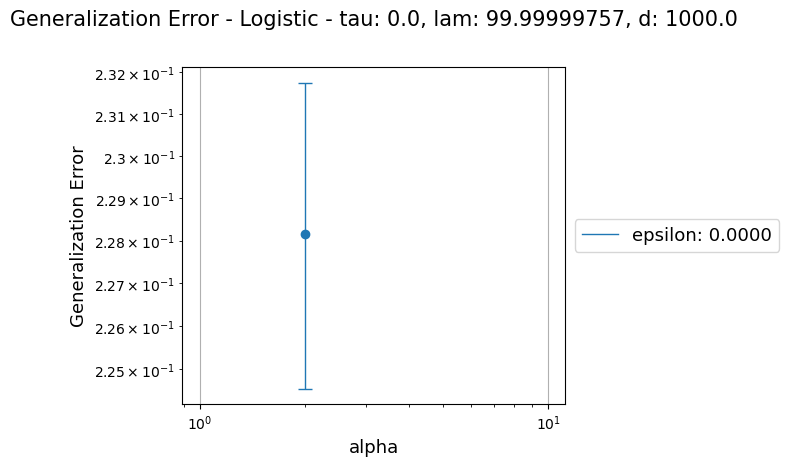

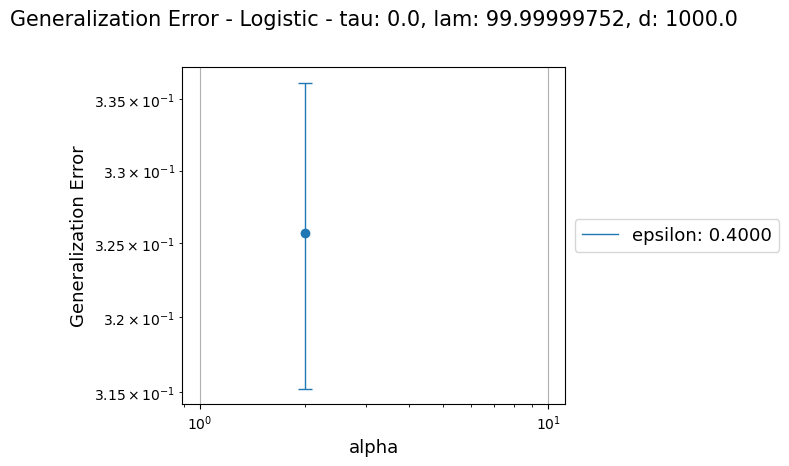

In [28]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm", log_y=True)

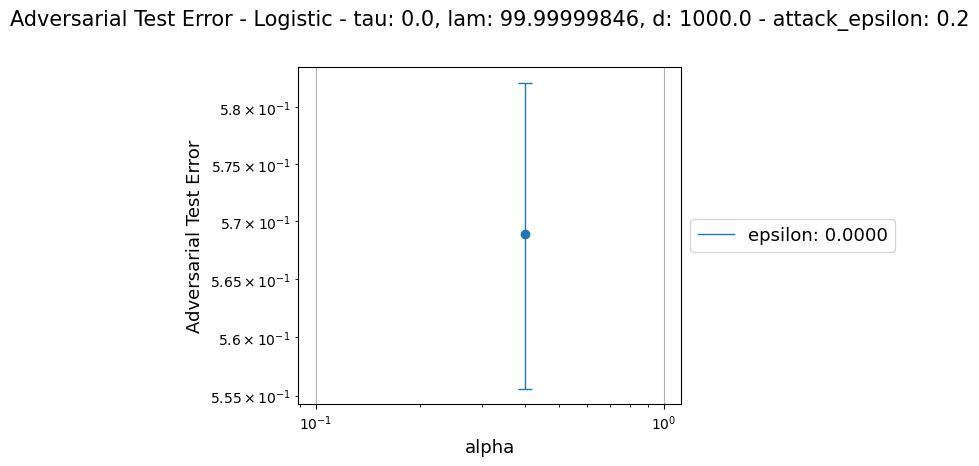

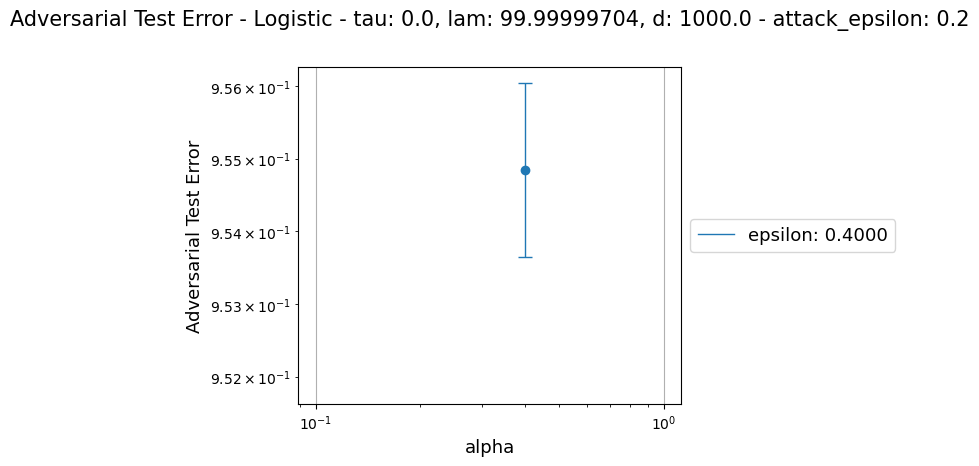

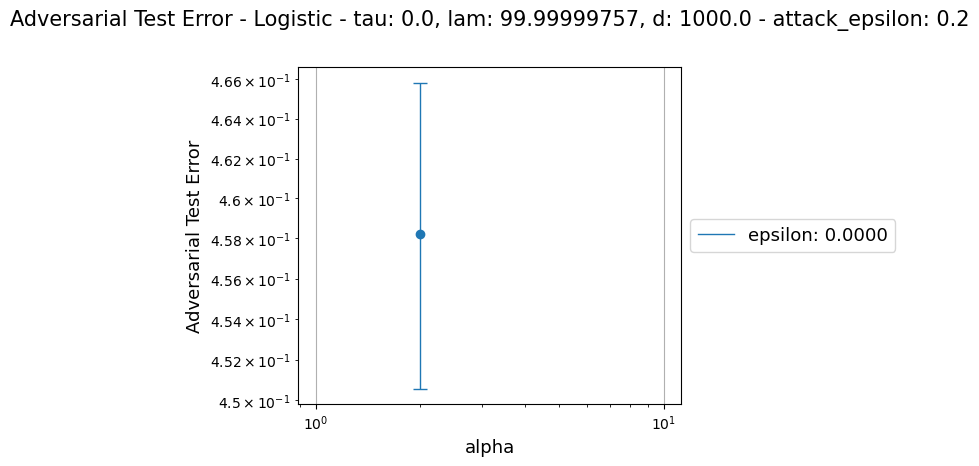

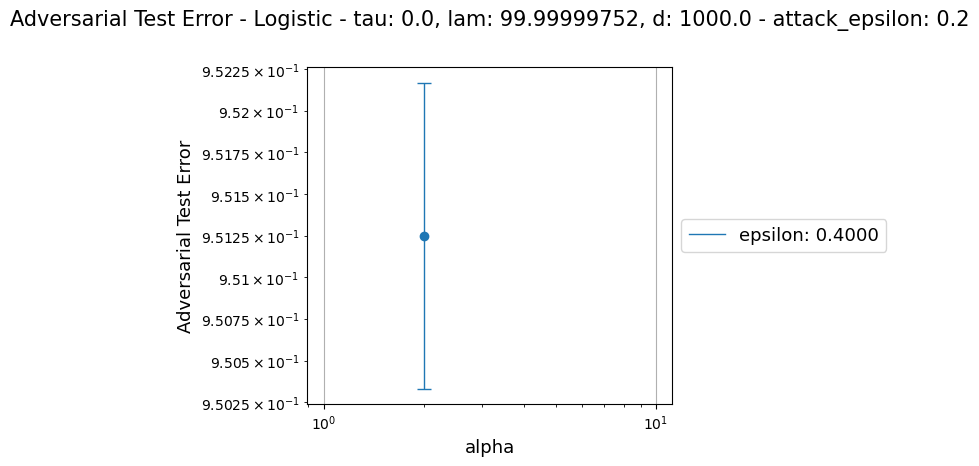

In [29]:
create_plot(df, "Adversarial Test Error", "adversarial_generalization_error_state_evolution", "adversarial_generalization_error_erm",log_y=True,log_x=True,plot_attack_epsilon=True)

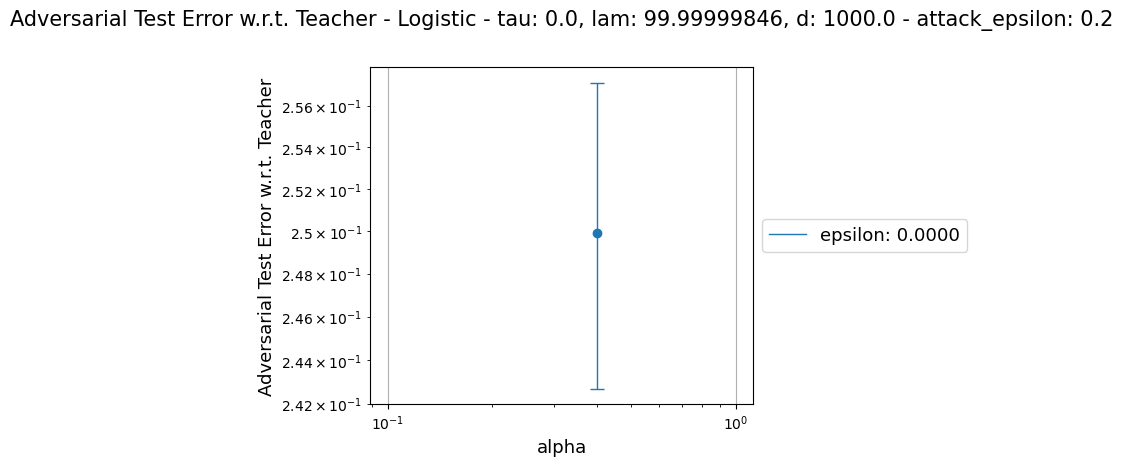

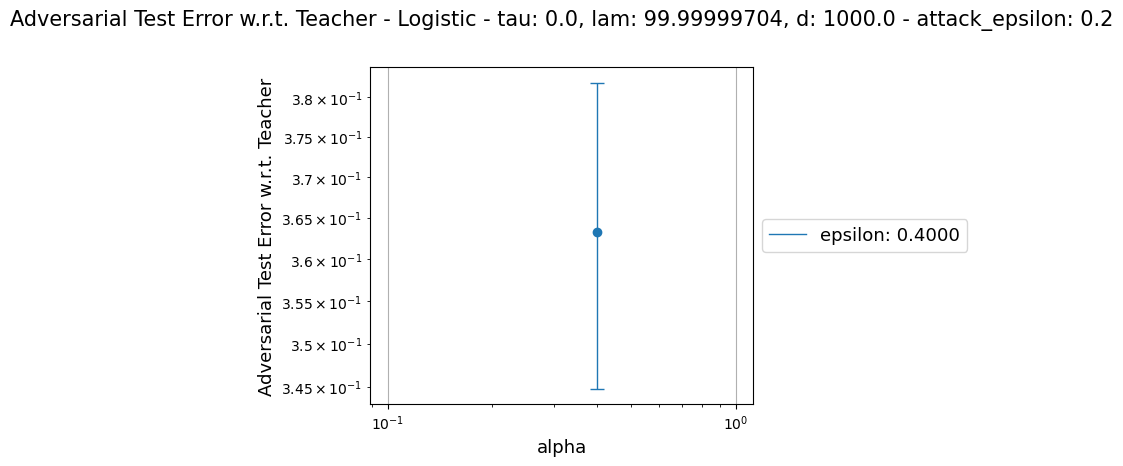

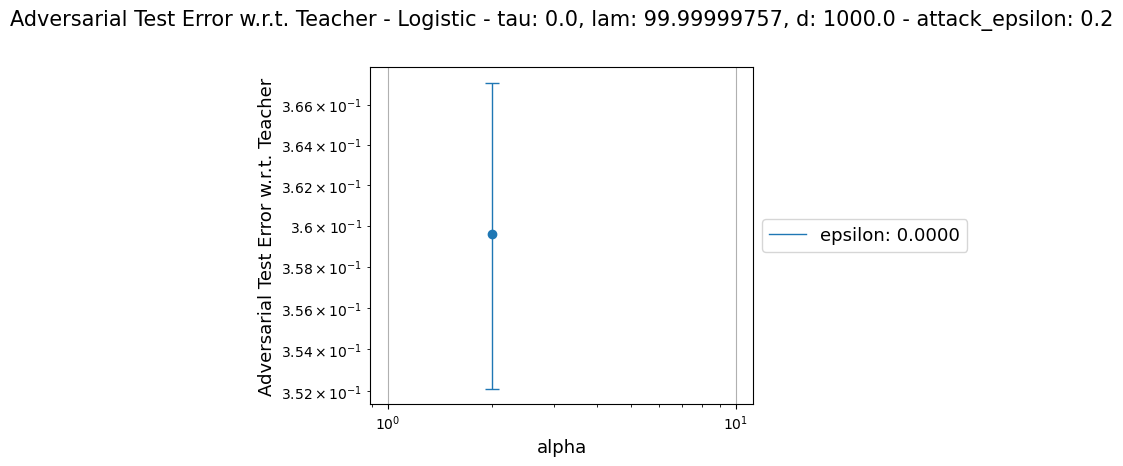

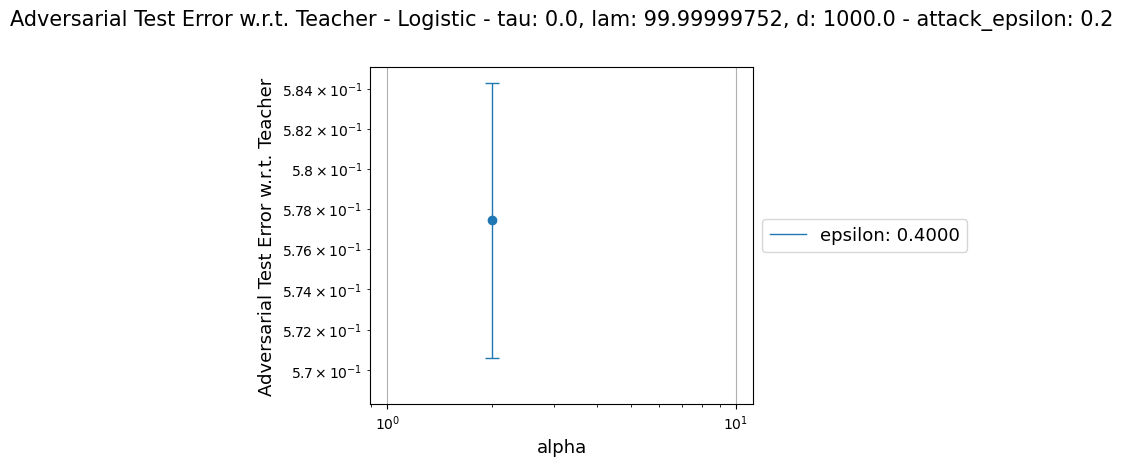

In [30]:
create_plot(df, "Adversarial Test Error w.r.t. Teacher", "adversarial_generalization_error_teacher_state_evolution", "adversarial_generalization_error_teacher_erm",log_y=True,log_x=True,plot_attack_epsilon=True)

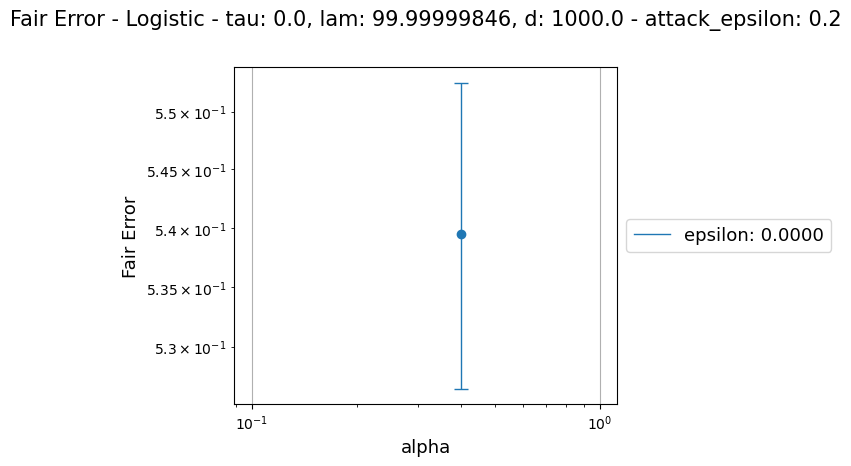

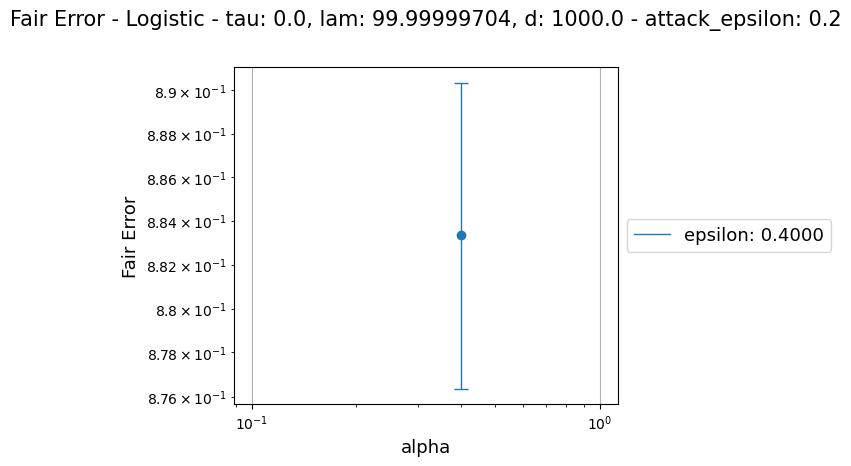

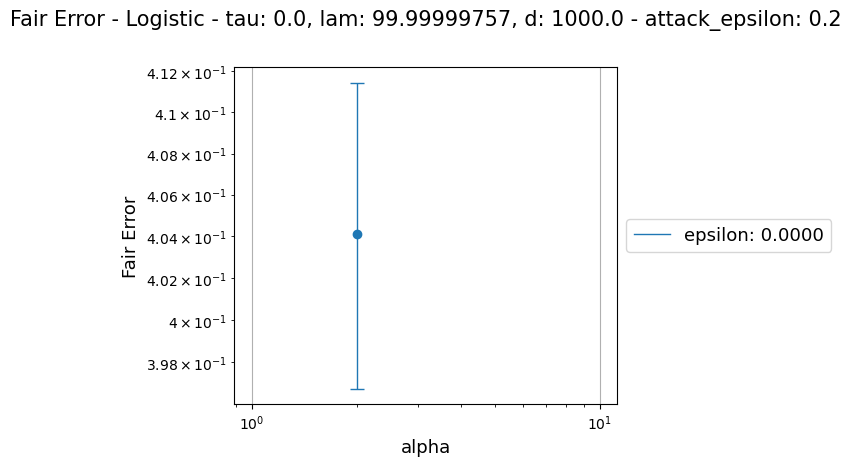

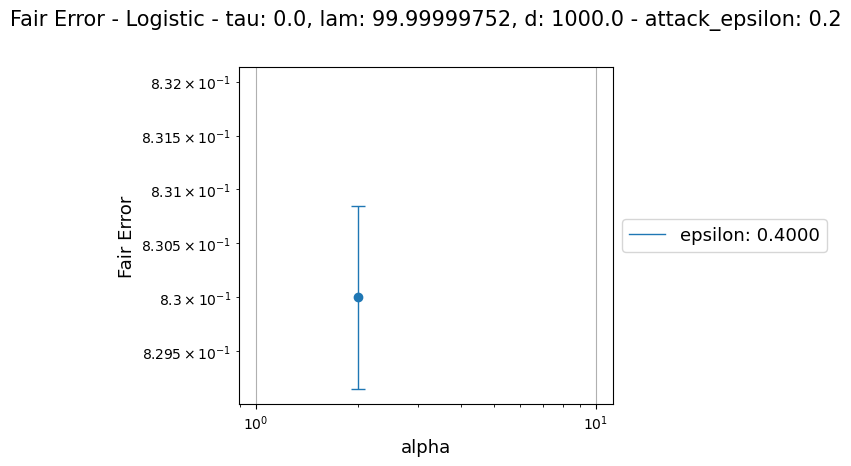

In [31]:
# plot the fair adversarial error
create_plot(df, "Fair Error", "fair_adversarial_error_state_evolution","fair_adversarial_error_erm",plot_attack_epsilon=True)

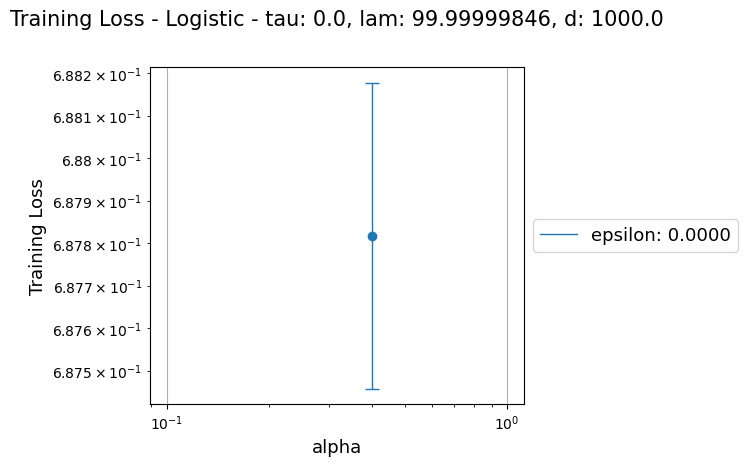

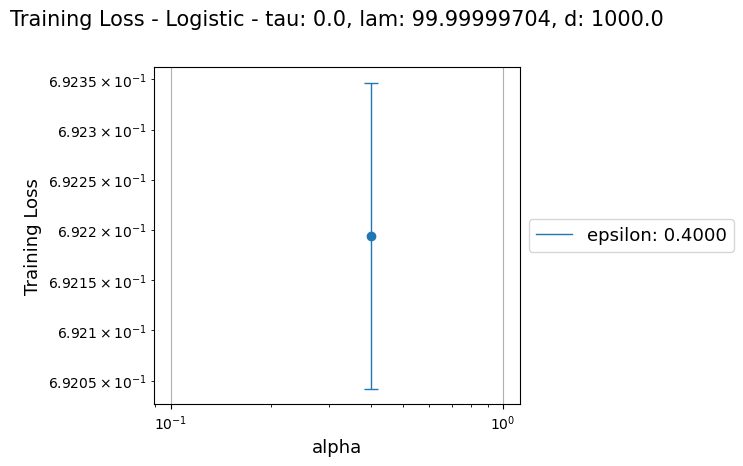

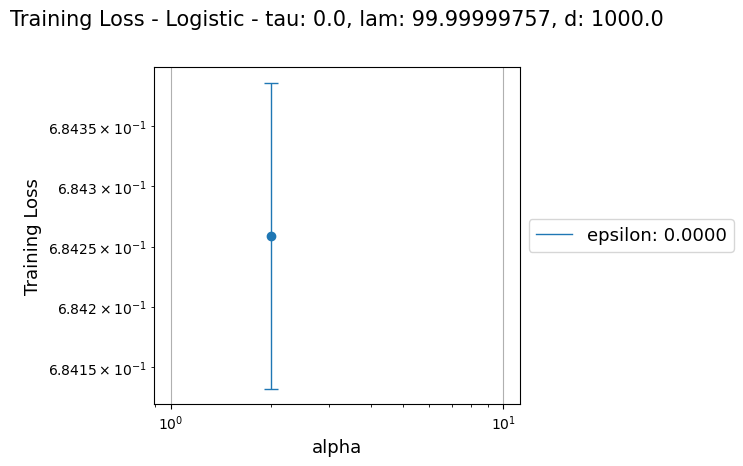

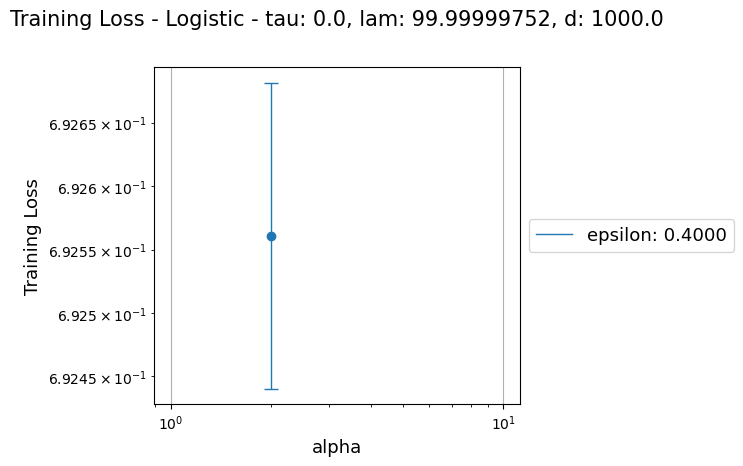

In [32]:
create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=True)

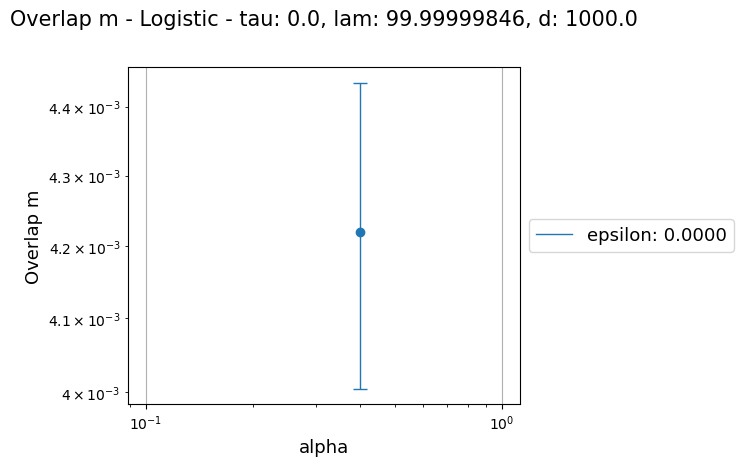

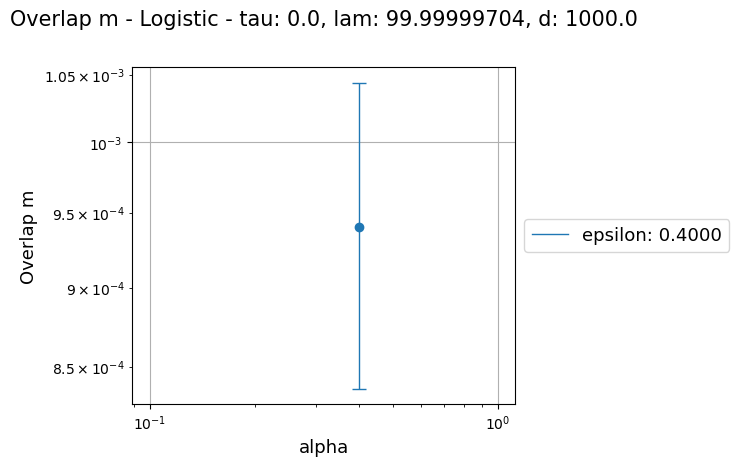

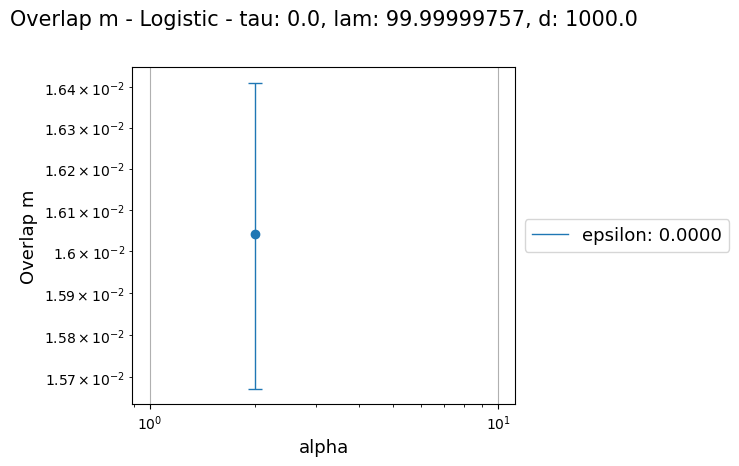

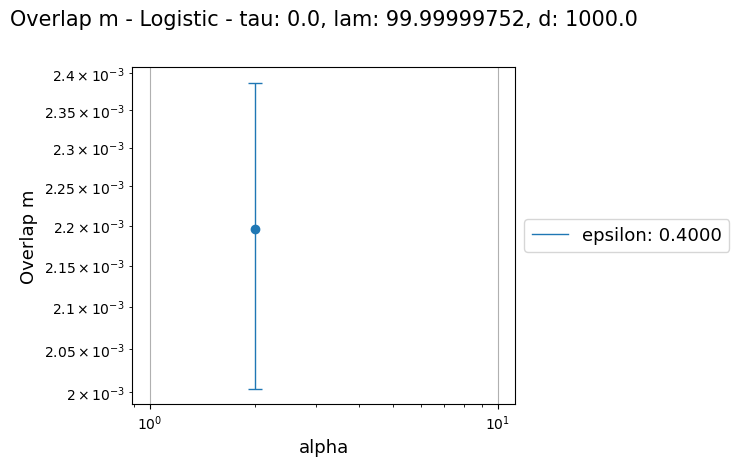

In [33]:
create_plot(df, "Overlap m", "m_state_evolution","m_erm")

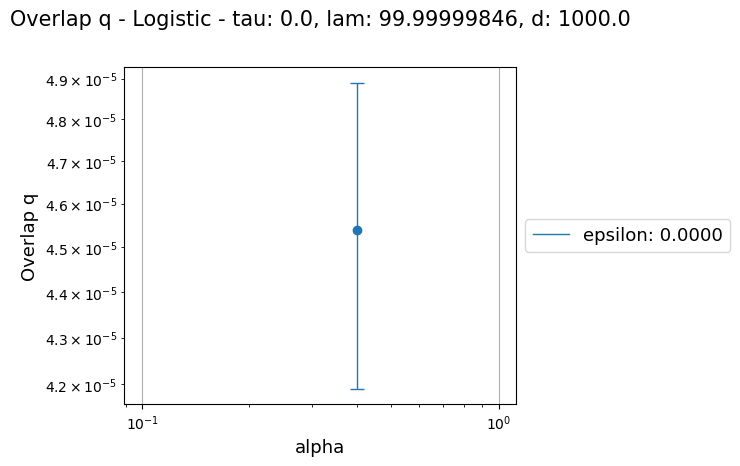

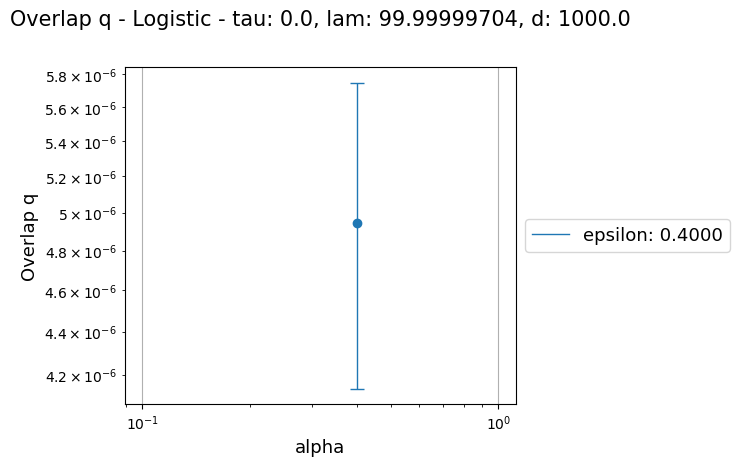

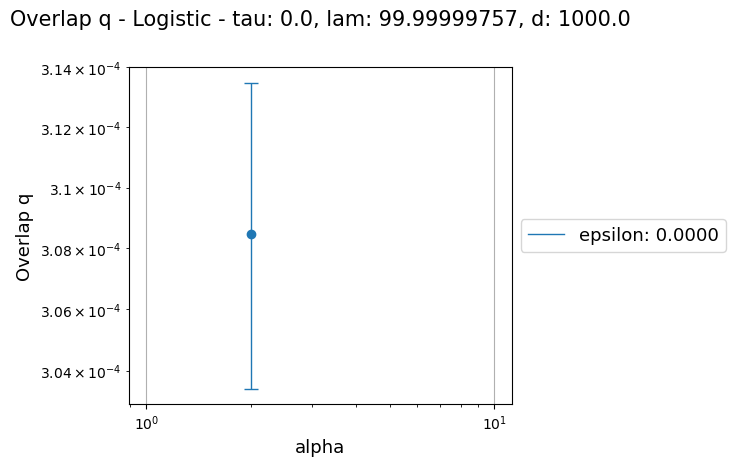

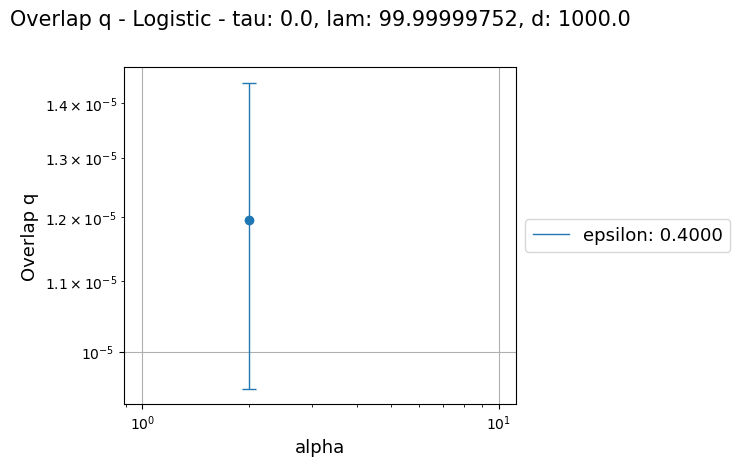

In [34]:
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_y=True)

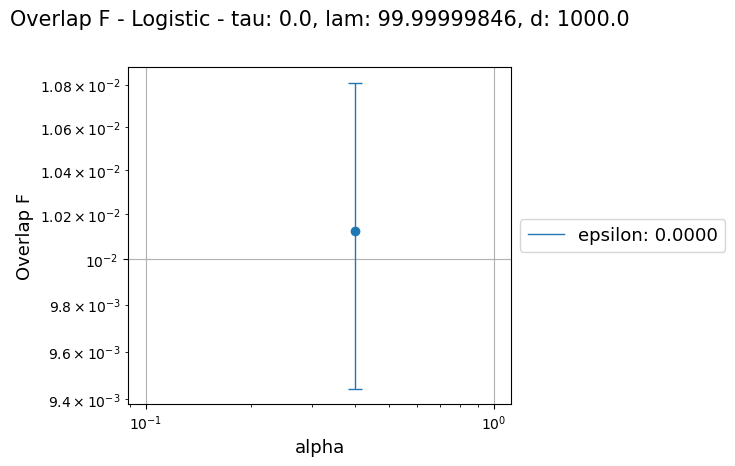

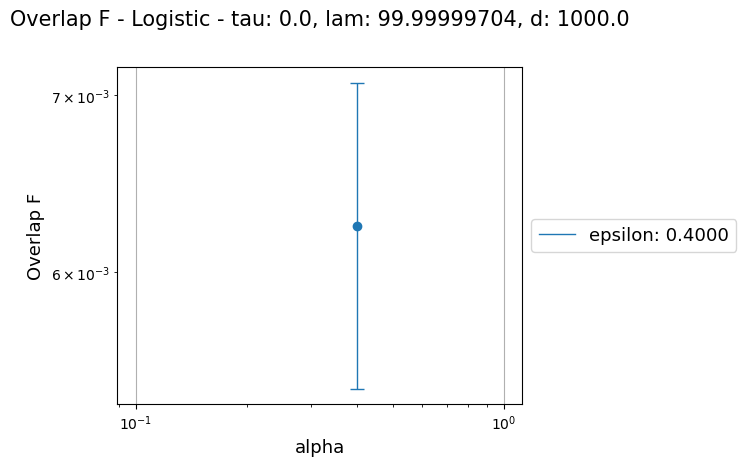

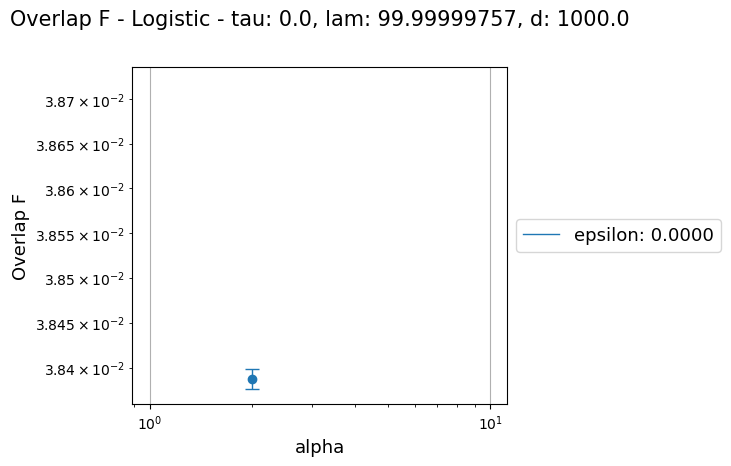

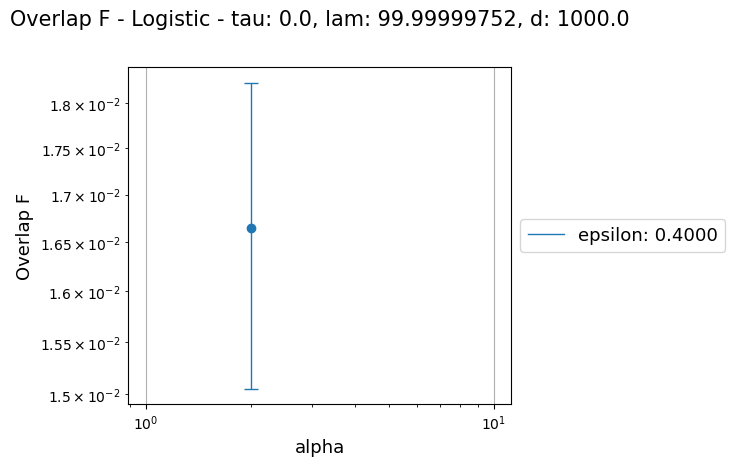

In [35]:
# Plot the F overlap
create_plot(df, "Overlap F", "F_state_evolution","F_erm", log_y=True)

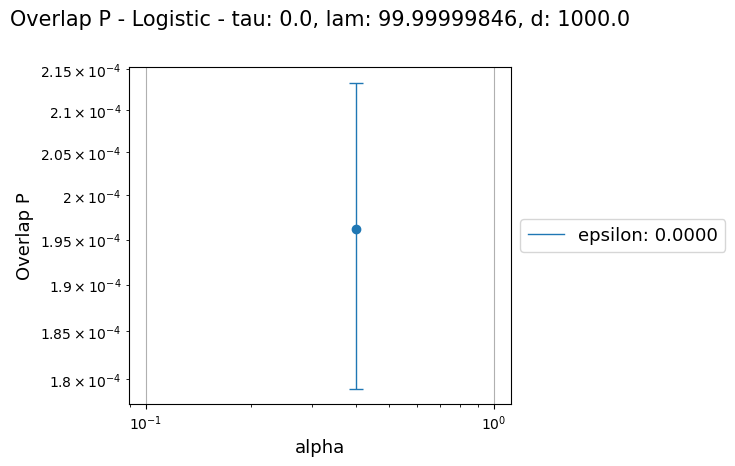

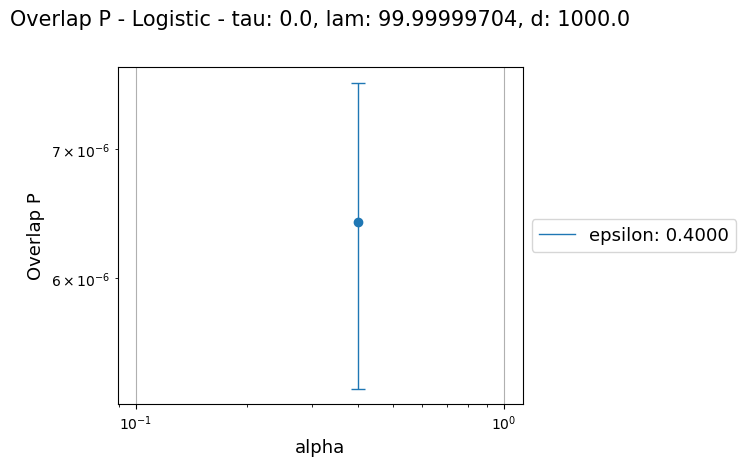

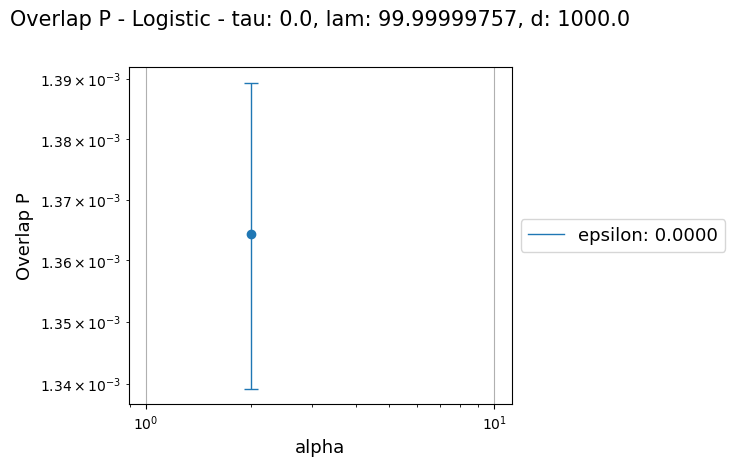

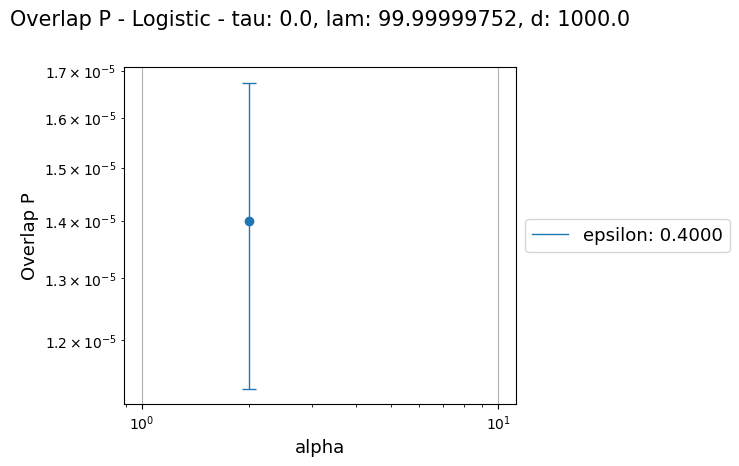

In [36]:
# Plot the P overlap
create_plot(df, "Overlap P", "P_state_evolution","P_erm", log_y=True)

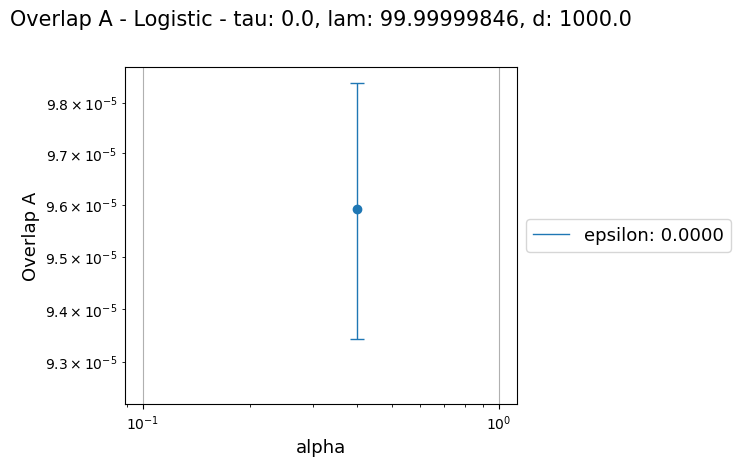

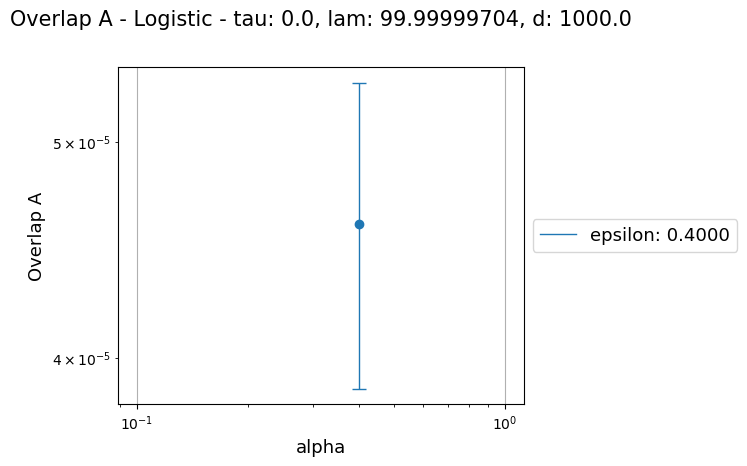

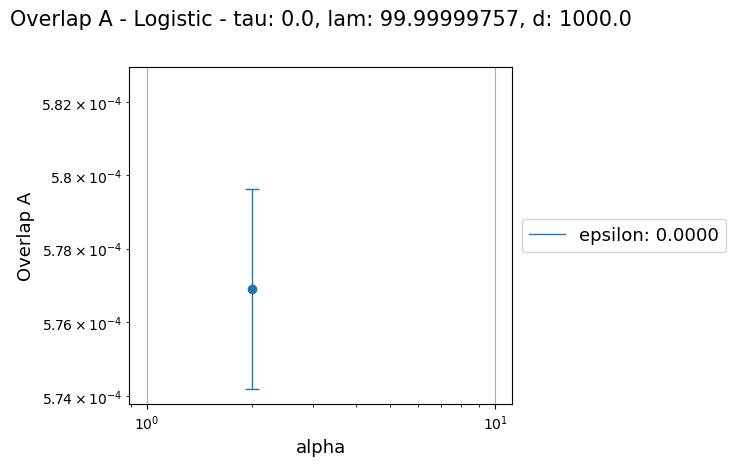

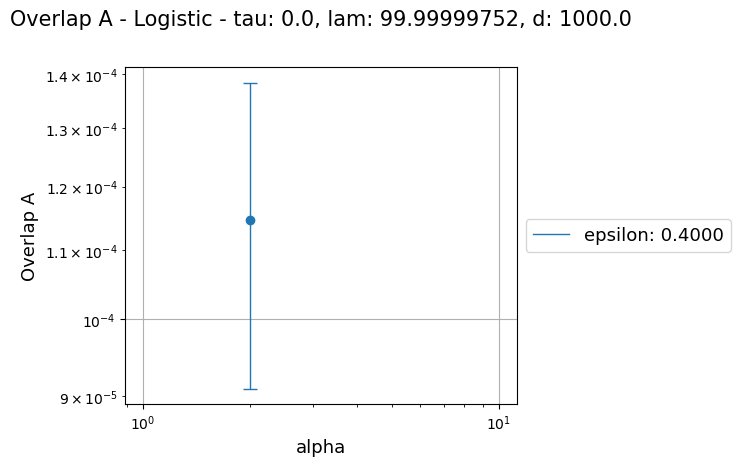

In [37]:
# Plot the A overlap
create_plot(df, "Overlap A", "A_state_evolution","A_erm", log_y=True)

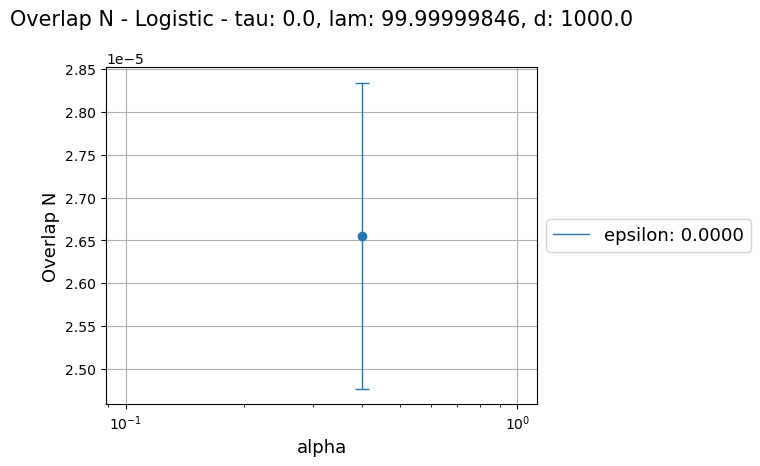

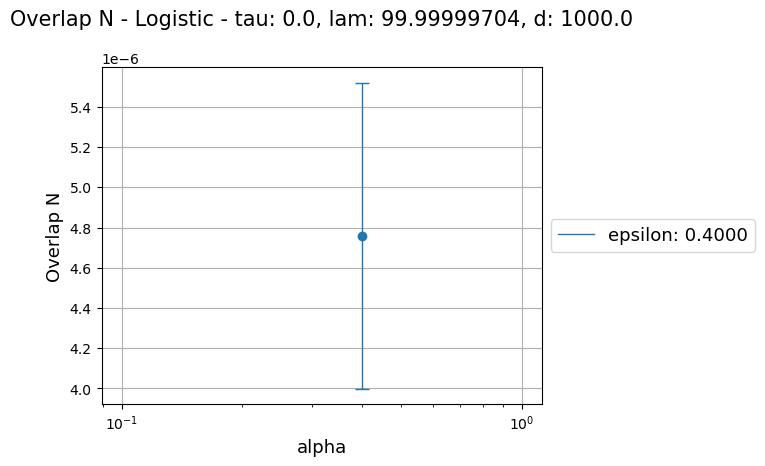

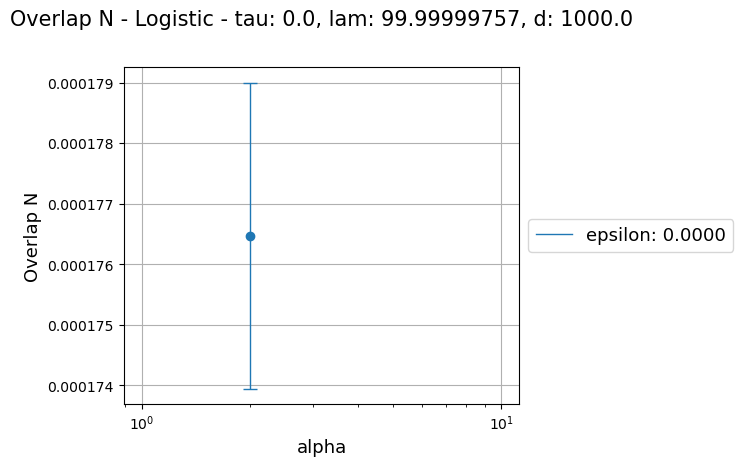

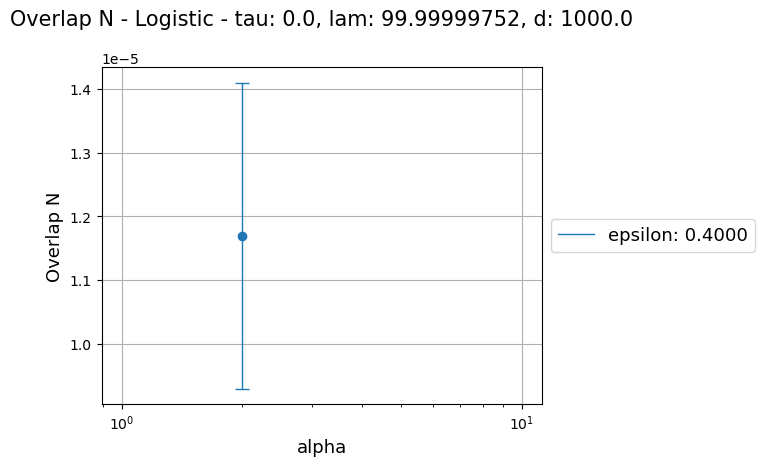

In [38]:
# Plot the N overlap
create_plot(df, "Overlap N", "N_state_evolution","N_erm", log_y=False)

In [39]:
# # subset df to keep only where p = 0.5
# p = 0.6
# dfp = df[df.index.get_level_values("p_calibration") == p]
# # remove epsilon = 1
# # dfp = dfp[dfp.index.get_level_values("epsilon") != 1]

# create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False)
# # erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

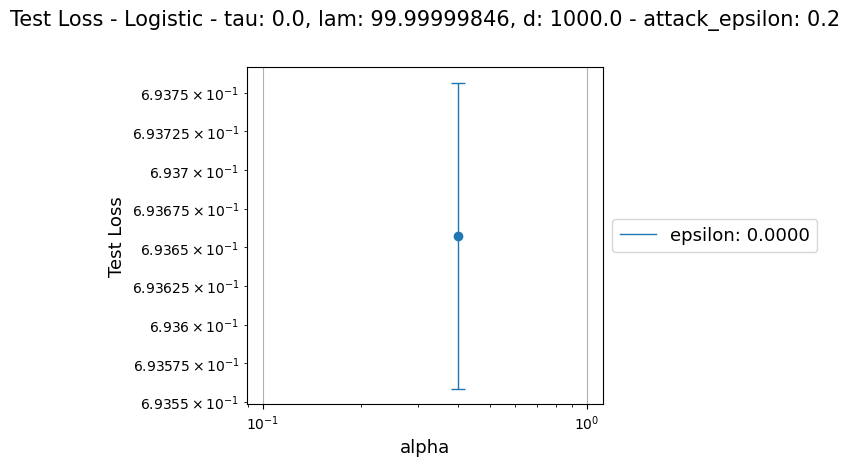

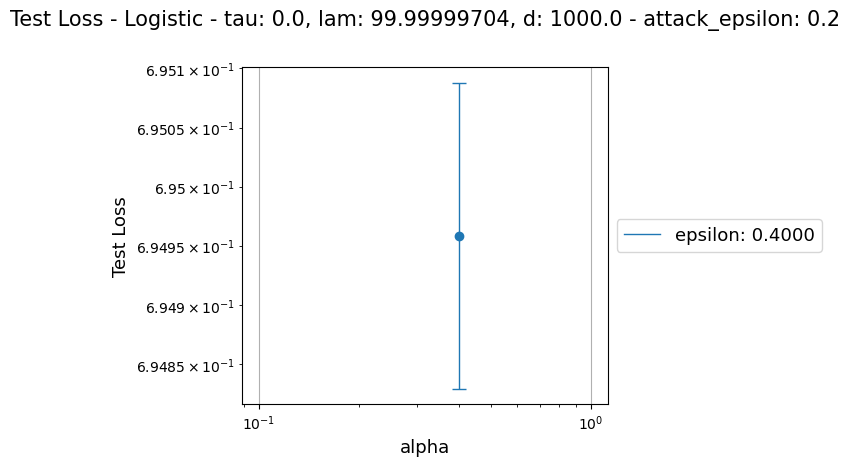

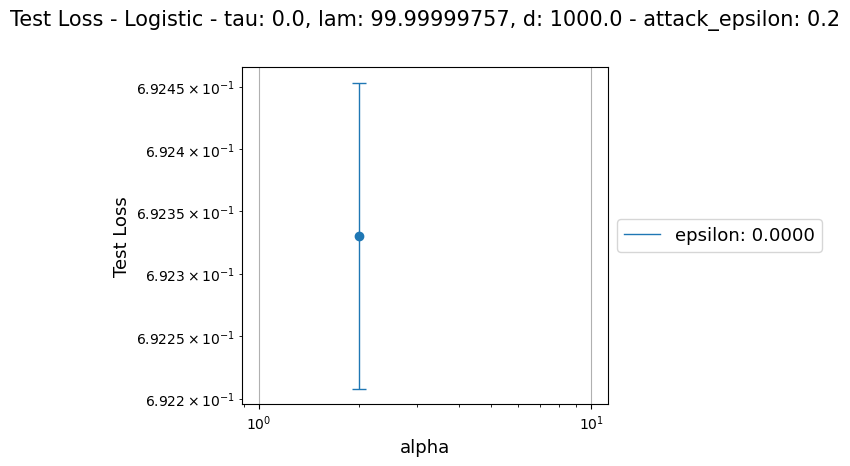

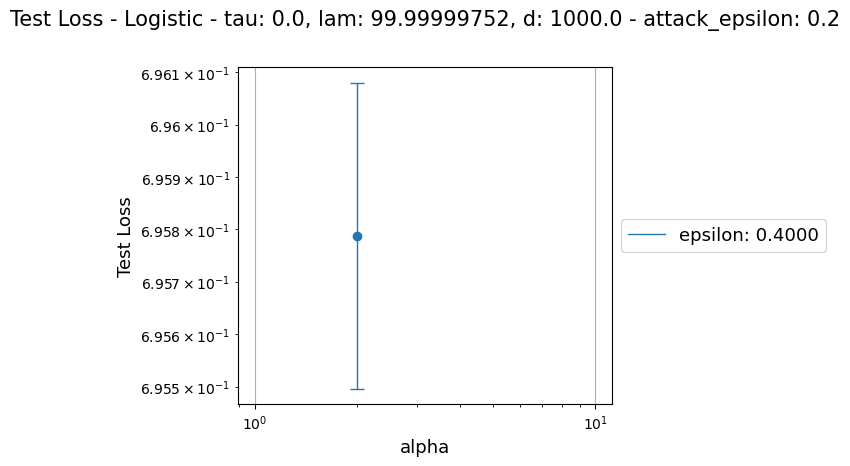

In [40]:
# plot test loss erm
create_plot(df, "Test Loss", "test_loss_state_evolution","test_loss_erm",log_y=True,plot_attack_epsilon=True)

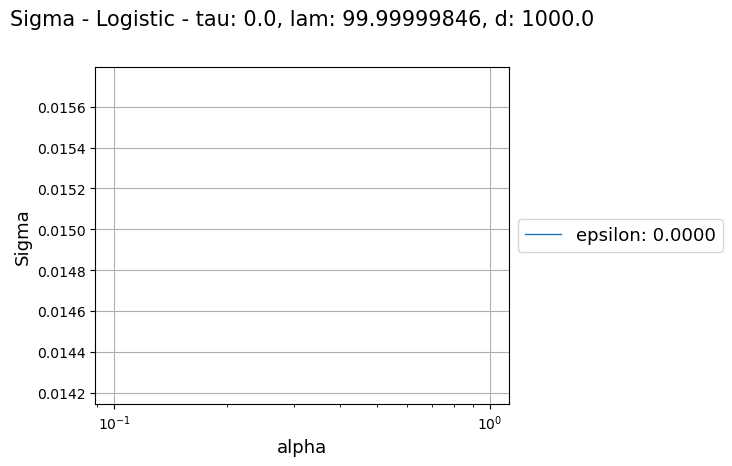

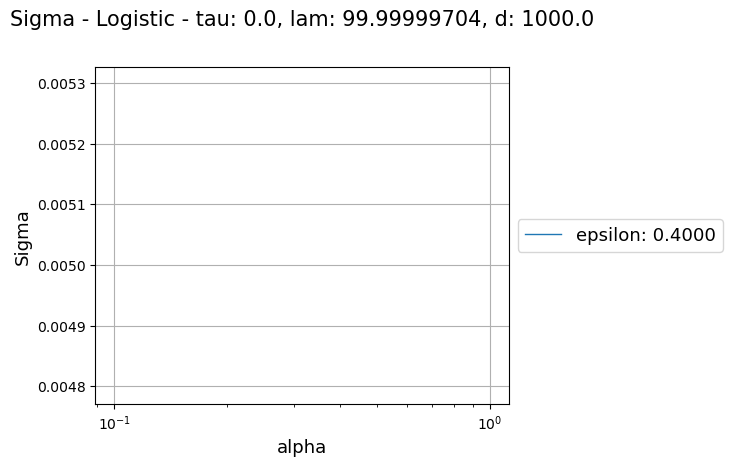

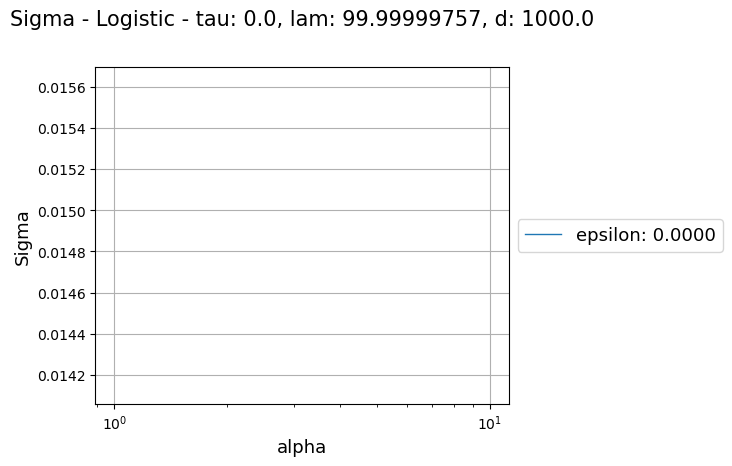

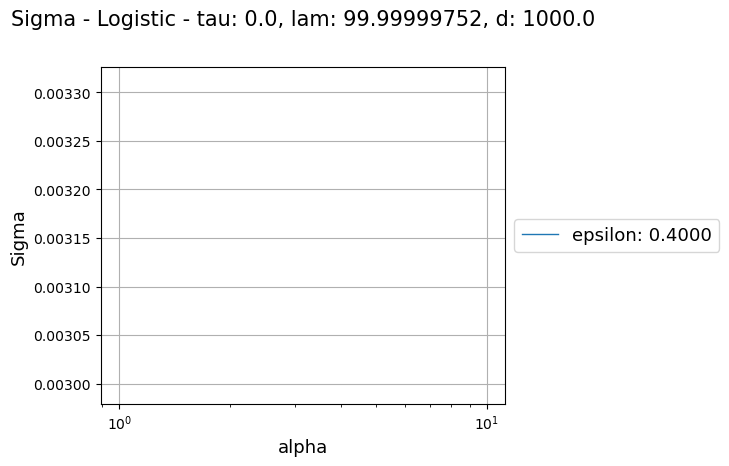

In [41]:
# Plot sigma for the state evolution
create_plot(df, "Sigma", "sigma_state_evolution", None, log_y=False)

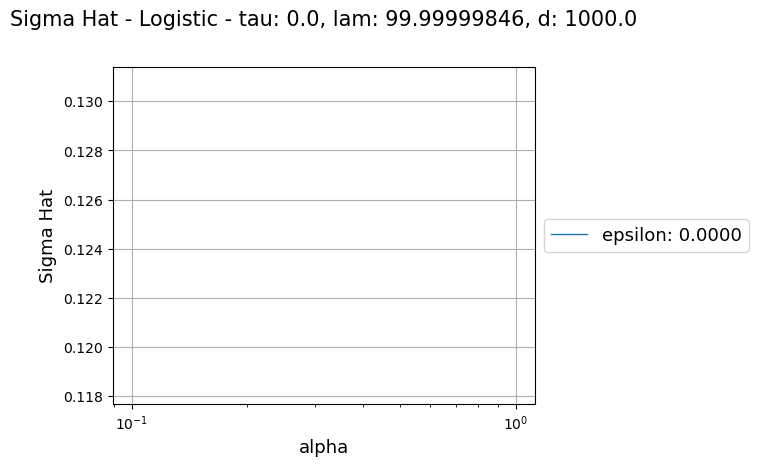

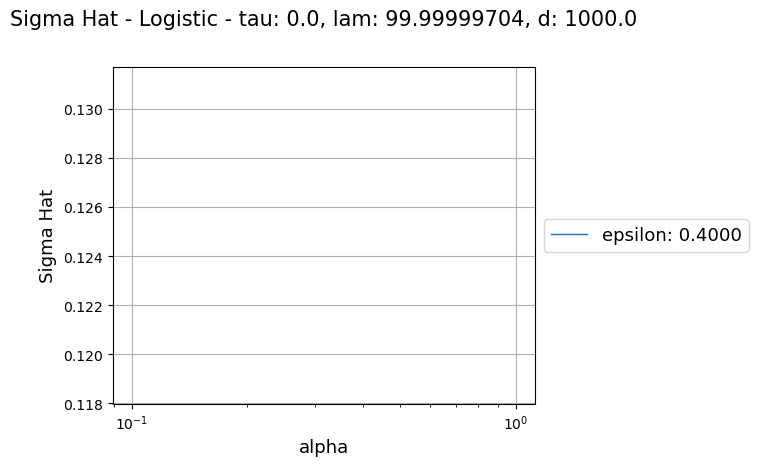

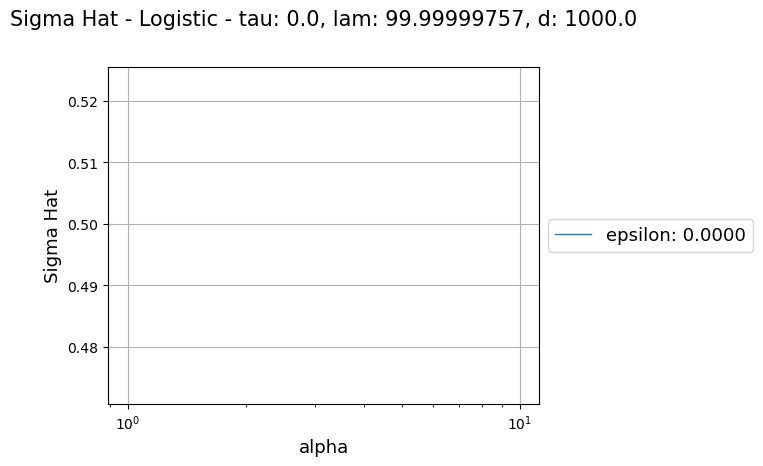

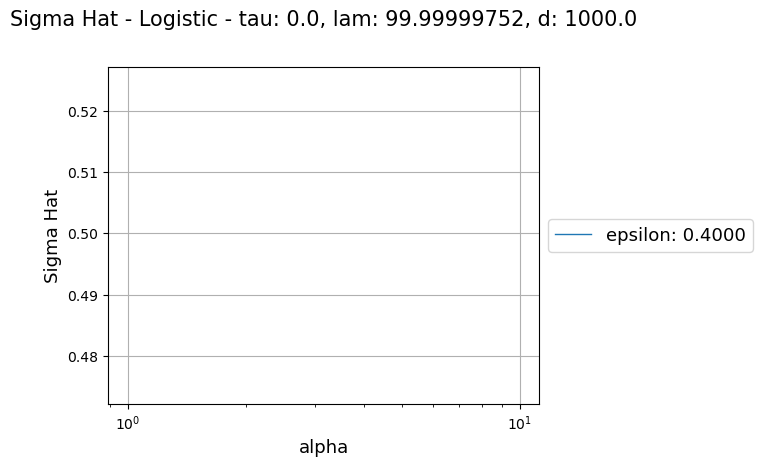

In [42]:
# Plot sigma_hat for the state evolution
create_plot(df, "Sigma Hat", "sigma_hat_state_evolution", None, log_y=False)

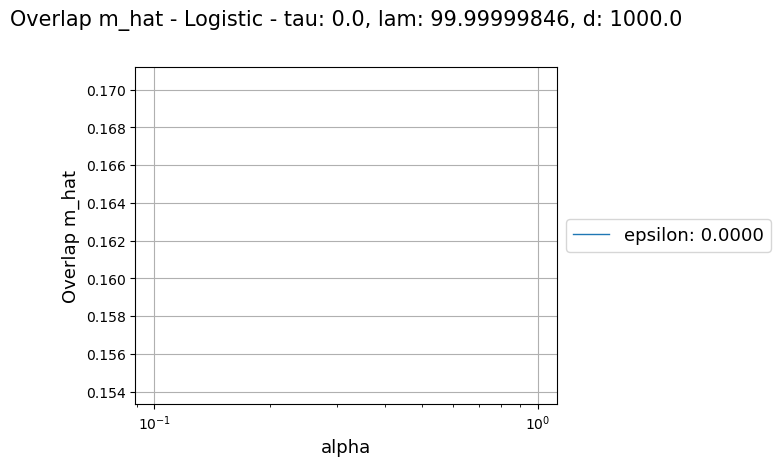

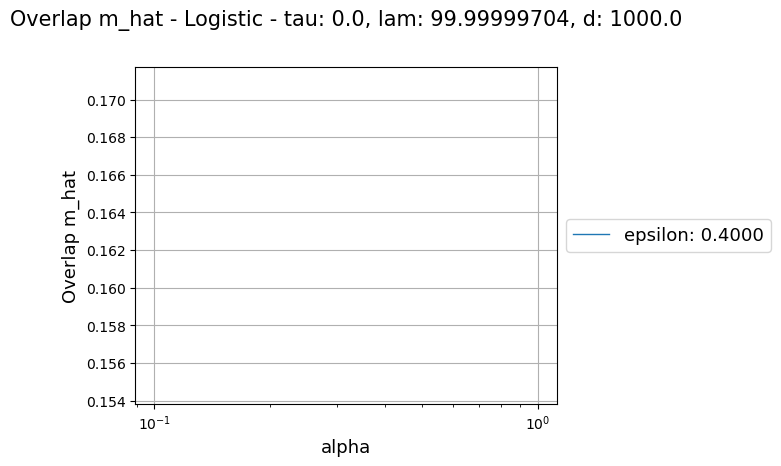

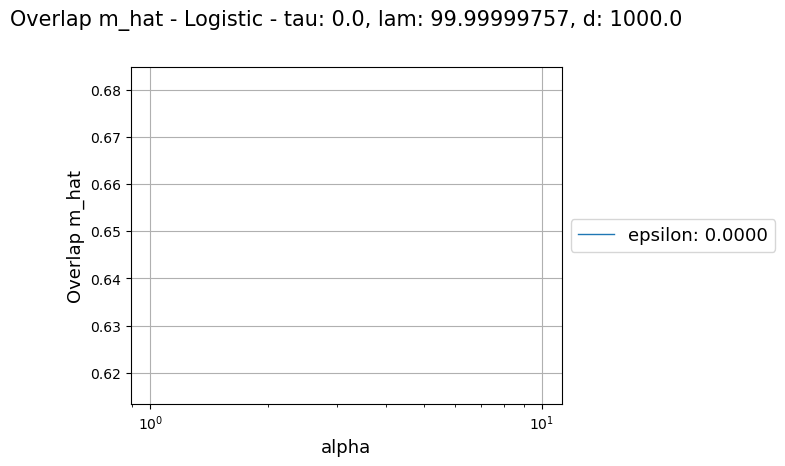

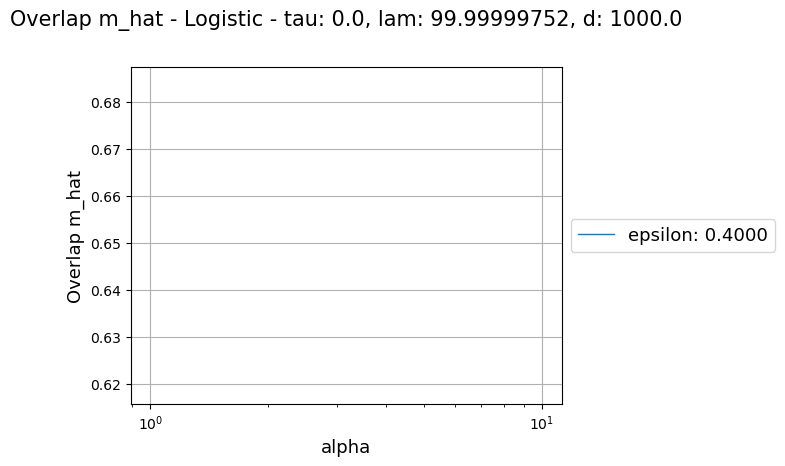

In [43]:
# Plot m_hat for the state evolution
create_plot(df, "Overlap m_hat", "m_hat_state_evolution", None, log_y=False)

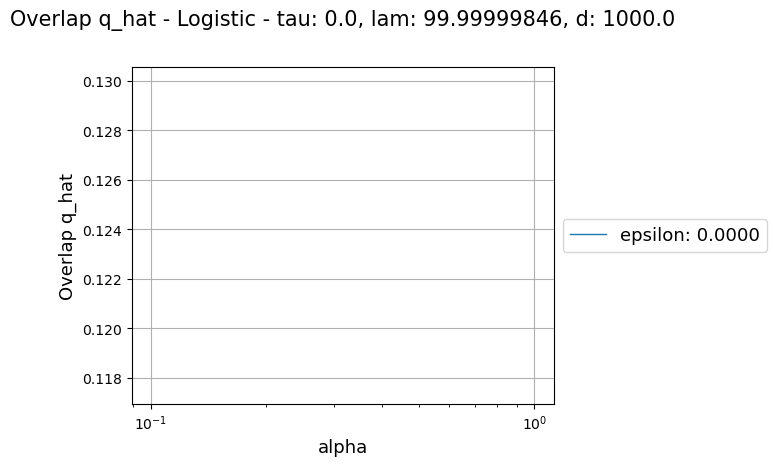

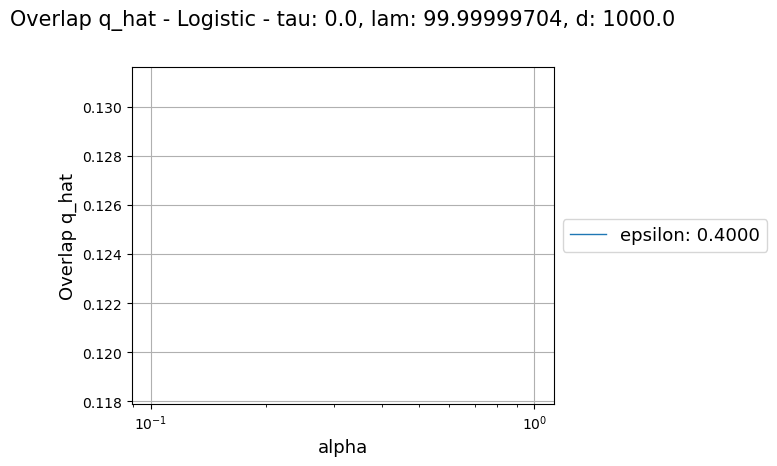

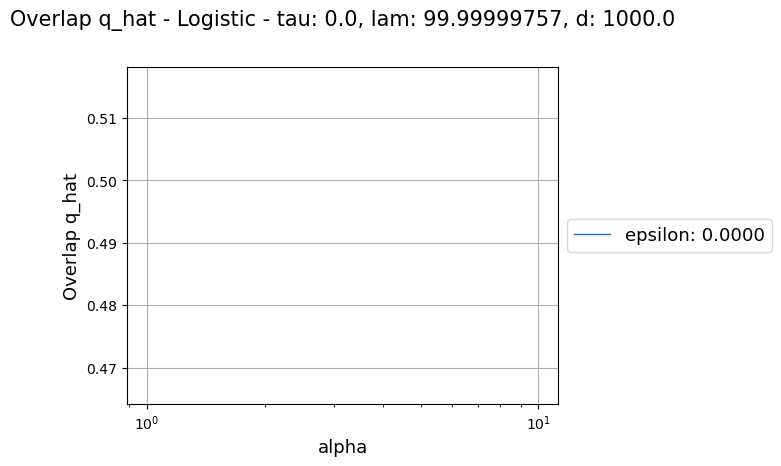

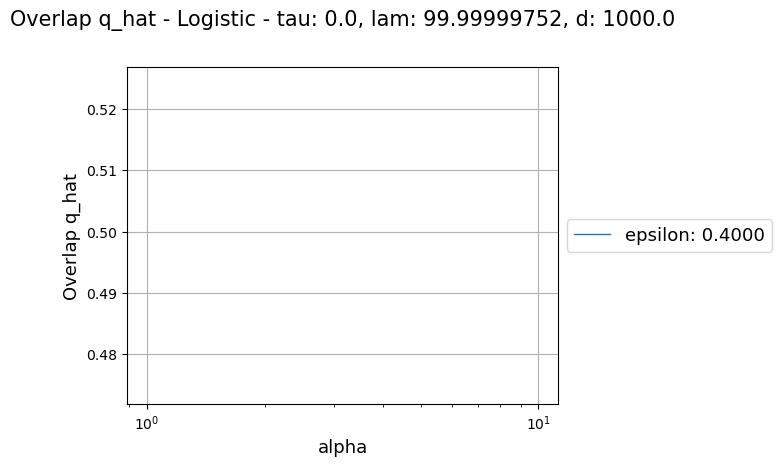

In [44]:
# Plot q_hat for the state_evolution
create_plot(df, "Overlap q_hat", "q_hat_state_evolution", None, log_y=False)

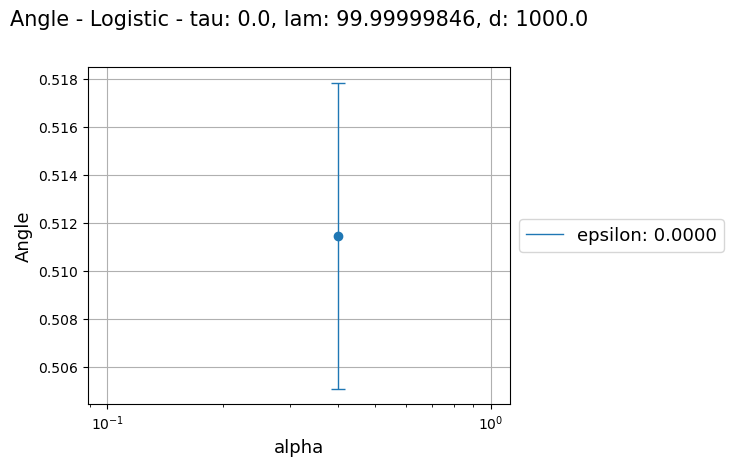

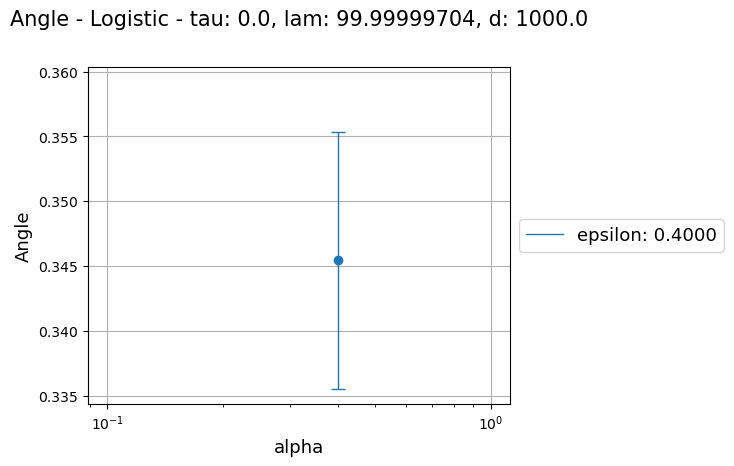

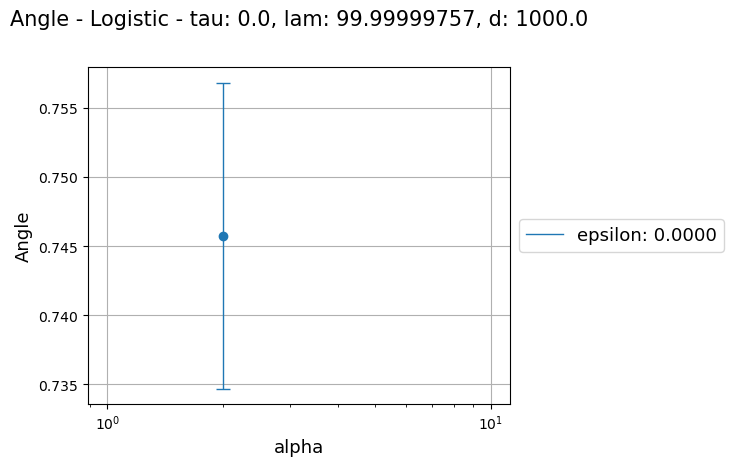

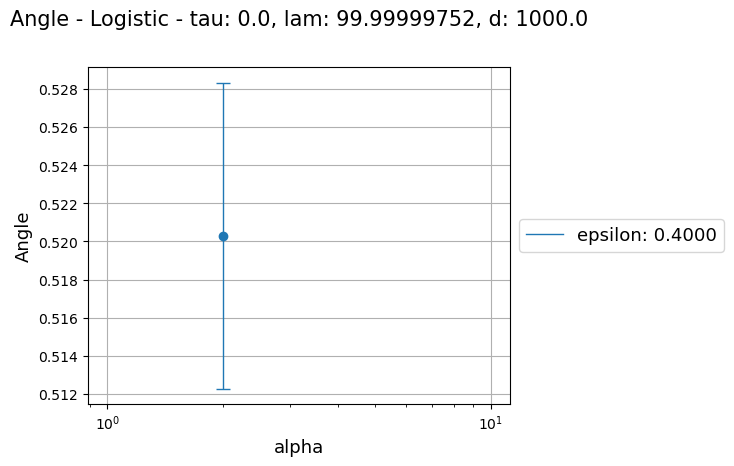

In [45]:
create_plot(df, "Angle", "angle_state_evolution","angle_erm",log_y=False)